In [1]:
import os
import copy
import time

import torch
import torch.nn as nn
import torchvision

from torchvision import datasets, models
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Const variables

# Dataset root
DATASET_DIR_ROOT = "../datasets/eye-dataset"

# Number of epochs
n_epochs = 90

# Input images size
image_size = 256

# Number of batches
batch_size = 32

# Number of workers for dataloaders
num_workers = 4

# **DATA LOADING**

In [3]:
# Define transforms for each dataset separately

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomRotation(45),
    transforms.RandomAdjustSharpness(1.3, 1),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

validation_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

In [4]:
# Load datasets

train_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "train"),
    transform=train_transforms
)

validation_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "validation"),
    transform=validation_transforms
)

test_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "test"),
    transform=test_transforms
)

In [5]:
# Instantiate DataLoaders

train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

validation_loader = DataLoader(
    dataset=validation_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# **DATA VISUALIZATION** 


In [6]:
sns.set_style('darkgrid')

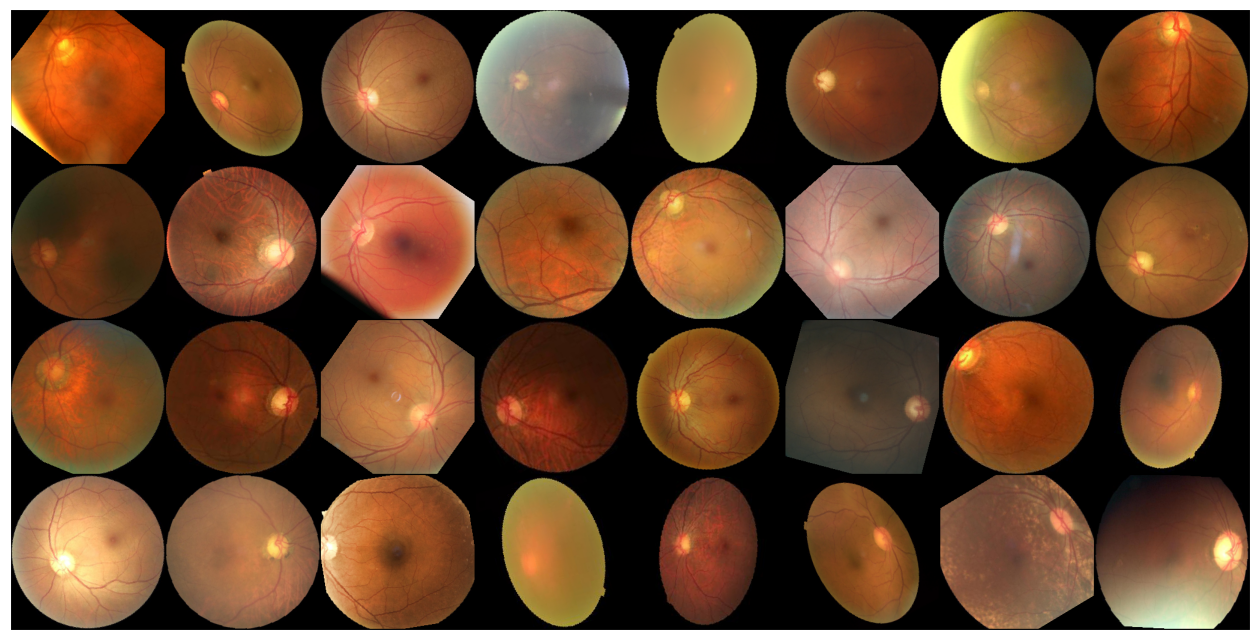

In [7]:
def grid_display(dataloader):
    """Plots a single batch of a dataloader. Denormalizes images for better visualization.

    :param dataloader: a DataLoader object that we want to display its images
    """
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
        break
        
grid_display(train_loader)

In [8]:
def label_distribution(dataset):
    """Counts the number of samples per label(class) in the dataset.
    
    :param dataset: the purpose dataset
    :type dataset: ImageFolder
    """
    encoded_labels = {v:k for k, v in dataset.class_to_idx.items()} # {0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}
    labels_count = {k:0 for k in dataset.class_to_idx} # {'cataract': 0, 'diabetic_retinopathy': 0, 'glaucoma': 0, 'normal': 0}

    for label_code in encoded_labels:
        labels_count[encoded_labels[label_code]] = dataset.targets.count(label_code)
    return labels_count

In [9]:
def plot_from_dict(dict_obj: dict, plot_title: str, **kwargs):
    """Plots a bar chart from a dictionry. keys: x_axis, values: y_axis
    
    :param dict_obj: the dictionary that would be plotted
    :param plot_title: title of the plot
    """
    df = pd.DataFrame.from_dict([dict_obj]).melt()
    df.rename(columns={'variable': 'Dataset Labels', 'value': 'Number of samples'}, inplace=True)
    return sns.barplot(
        data=df,
        x="Dataset Labels",
        y="Number of samples",
        hue="Dataset Labels",
        **kwargs
    ).set_title(label=plot_title)

Text(0.5, 1.0, 'Test Set')

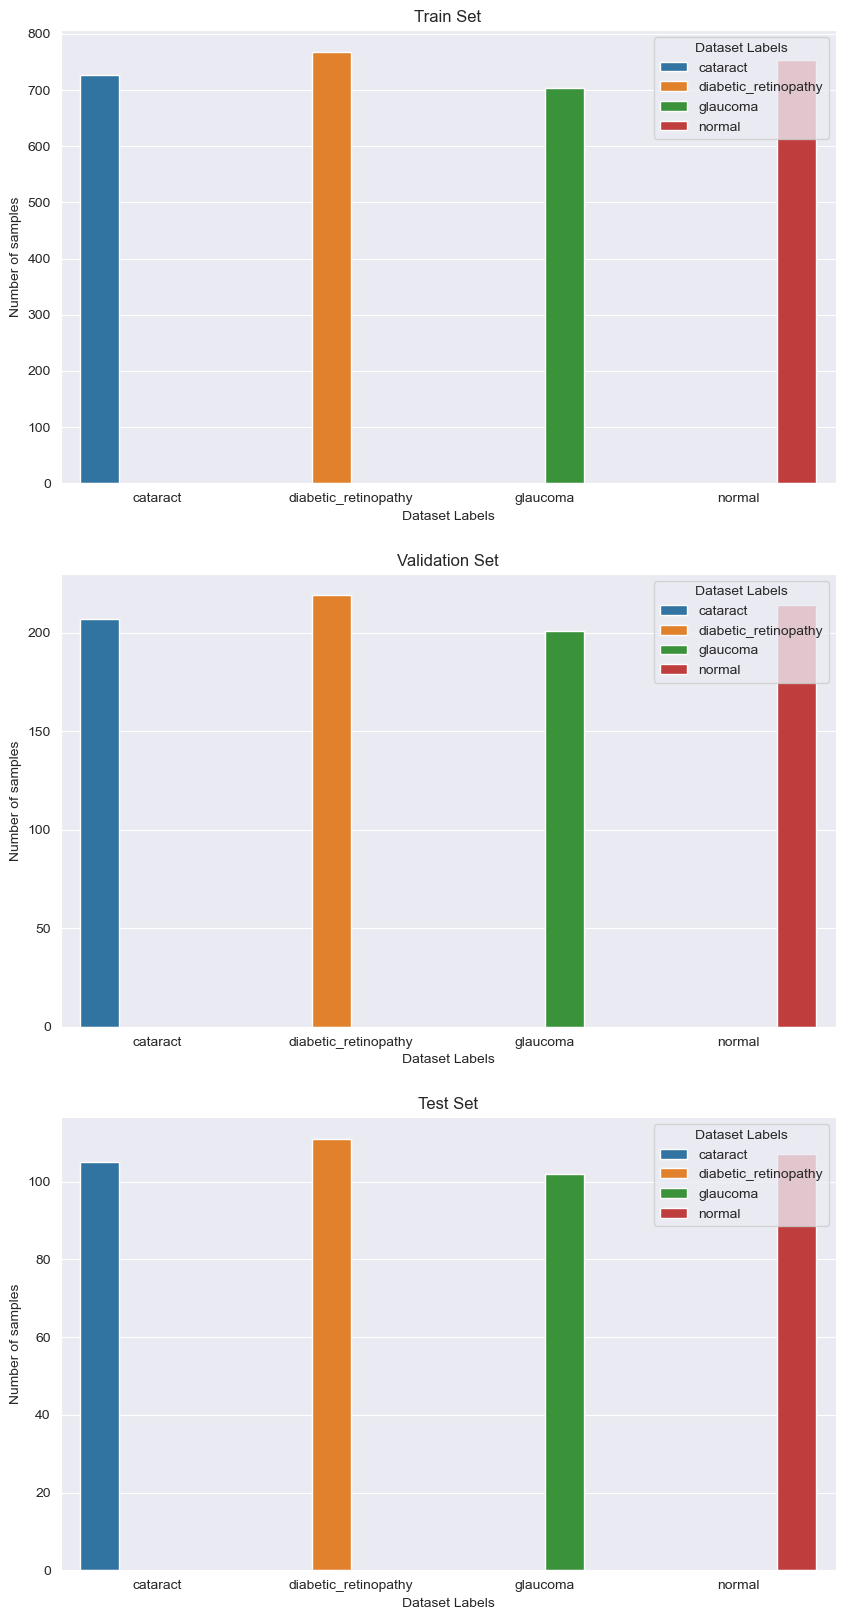

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
plot_from_dict(label_distribution(train_set), plot_title="Train Set", ax=axes[0])
plot_from_dict(label_distribution(validation_set), plot_title="Validation Set", ax=axes[1])
plot_from_dict(label_distribution(test_set), plot_title="Test Set", ax=axes[2])

# **MODEL**

In [11]:
class EyeSeeNet(nn.Module):
    def __init__(self, num_class):
        super(EyeSeeNet, self).__init__()
        self.num_class = num_class
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64*14*14, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_class)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*14*14)
        x = self.fc(x)
        return x

In [12]:
# Summary of the architecture of RetinalEnsemble

summary(EyeSeeNet(4), (3, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 14, 14]          --
|    └─Conv2d: 2-1                       [-1, 32, 254, 254]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 254, 254]        64
|    └─ReLU: 2-3                         [-1, 32, 254, 254]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 127, 127]        --
|    └─Conv2d: 2-5                       [-1, 16, 125, 125]        4,624
|    └─BatchNorm2d: 2-6                  [-1, 16, 125, 125]        32
|    └─ReLU: 2-7                         [-1, 16, 125, 125]        --
|    └─MaxPool2d: 2-8                    [-1, 16, 62, 62]          --
|    └─Conv2d: 2-9                       [-1, 32, 60, 60]          4,640
|    └─BatchNorm2d: 2-10                 [-1, 32, 60, 60]          64
|    └─ReLU: 2-11                        [-1, 32, 60, 60]          --
|    └─MaxPool2d: 2-12                   [-1, 32, 30, 30]          --
|    └─C

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 14, 14]          --
|    └─Conv2d: 2-1                       [-1, 32, 254, 254]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 254, 254]        64
|    └─ReLU: 2-3                         [-1, 32, 254, 254]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 127, 127]        --
|    └─Conv2d: 2-5                       [-1, 16, 125, 125]        4,624
|    └─BatchNorm2d: 2-6                  [-1, 16, 125, 125]        32
|    └─ReLU: 2-7                         [-1, 16, 125, 125]        --
|    └─MaxPool2d: 2-8                    [-1, 16, 62, 62]          --
|    └─Conv2d: 2-9                       [-1, 32, 60, 60]          4,640
|    └─BatchNorm2d: 2-10                 [-1, 32, 60, 60]          64
|    └─ReLU: 2-11                        [-1, 32, 60, 60]          --
|    └─MaxPool2d: 2-12                   [-1, 32, 30, 30]          --
|    └─C

In [13]:
# Define device : GPU, MPS, or CPU

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"
    
print(device)

mps


In [14]:
# Instanciate and Transfer model on the device

model = EyeSeeNet(4).to(device)

In [15]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# **TRAIN THE MODEL**

In [16]:
# Train model

train_losses = np.zeros(n_epochs)
val_losses = np.zeros(n_epochs)
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
since = time.time()

for epoch in range(n_epochs):
    train_corrects = 0
    train_loss = 0.0

    model.train()
    for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{n_epochs}'):

        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == targets.data)
        train_loss += loss.item() * inputs.size(0)

        loss.backward()
        optimizer.step()
            
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_corrects / len(train_loader.dataset)
    
    with torch.no_grad():
        val_corrects = 0
        val_loss = 0.0
        model.eval()

        for inputs, targets in tqdm(validation_loader, desc=f'Validating... Epoch: {epoch + 1}/{n_epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == targets.data)
            val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(validation_loader.dataset)
        val_acc = val_corrects / len(validation_loader.dataset)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # save epoch losses
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    
    print(f"Epoch {epoch+1}/{n_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print('-'*30)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
model.load_state_dict(best_model_wts)

Validating... Epoch: 1/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 1/90:
Train Loss: 1.1747, Train Accuracy: 0.4971
Validation Loss: 1.1157, Validation Accuracy: 0.5268
------------------------------


Validating... Epoch: 2/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 2/90:
Train Loss: 0.8658, Train Accuracy: 0.6428
Validation Loss: 0.8525, Validation Accuracy: 0.6599
------------------------------


Validating... Epoch: 3/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 3/90:
Train Loss: 0.7110, Train Accuracy: 0.7089
Validation Loss: 0.7575, Validation Accuracy: 0.6992
------------------------------


Validating... Epoch: 4/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 4/90:
Train Loss: 0.6573, Train Accuracy: 0.7296
Validation Loss: 0.7679, Validation Accuracy: 0.6766
------------------------------


Validating... Epoch: 5/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 5/90:
Train Loss: 0.5599, Train Accuracy: 0.7797
Validation Loss: 0.6484, Validation Accuracy: 0.7384
------------------------------


Validating... Epoch: 6/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 6/90:
Train Loss: 0.5597, Train Accuracy: 0.7818
Validation Loss: 0.5612, Validation Accuracy: 0.7753
------------------------------


Validating... Epoch: 7/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 7/90:
Train Loss: 0.5084, Train Accuracy: 0.7848
Validation Loss: 0.6025, Validation Accuracy: 0.7432
------------------------------


Validating... Epoch: 8/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 8/90:
Train Loss: 0.4872, Train Accuracy: 0.8072
Validation Loss: 0.5164, Validation Accuracy: 0.7979
------------------------------


Validating... Epoch: 9/90: 100%|██████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 9/90:
Train Loss: 0.4852, Train Accuracy: 0.8085
Validation Loss: 0.4865, Validation Accuracy: 0.8157
------------------------------


Validating... Epoch: 10/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 10/90:
Train Loss: 0.4411, Train Accuracy: 0.8279
Validation Loss: 0.5557, Validation Accuracy: 0.7646
------------------------------


Validating... Epoch: 11/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 11/90:
Train Loss: 0.4293, Train Accuracy: 0.8197
Validation Loss: 0.4835, Validation Accuracy: 0.8252
------------------------------


Validating... Epoch: 12/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 12/90:
Train Loss: 0.4131, Train Accuracy: 0.8370
Validation Loss: 0.4273, Validation Accuracy: 0.8466
------------------------------


Validating... Epoch: 13/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 13/90:
Train Loss: 0.4262, Train Accuracy: 0.8336
Validation Loss: 0.4336, Validation Accuracy: 0.8430
------------------------------


Validating... Epoch: 14/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 14/90:
Train Loss: 0.3922, Train Accuracy: 0.8380
Validation Loss: 0.4444, Validation Accuracy: 0.8359
------------------------------


Validating... Epoch: 15/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 15/90:
Train Loss: 0.3781, Train Accuracy: 0.8539
Validation Loss: 0.4260, Validation Accuracy: 0.8430
------------------------------


Validating... Epoch: 16/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 16/90:
Train Loss: 0.3606, Train Accuracy: 0.8462
Validation Loss: 0.4097, Validation Accuracy: 0.8430
------------------------------


Validating... Epoch: 17/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 17/90:
Train Loss: 0.3724, Train Accuracy: 0.8472
Validation Loss: 0.4241, Validation Accuracy: 0.8454
------------------------------


Validating... Epoch: 18/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 18/90:
Train Loss: 0.3569, Train Accuracy: 0.8590
Validation Loss: 0.3978, Validation Accuracy: 0.8609
------------------------------


Validating... Epoch: 19/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 19/90:
Train Loss: 0.3514, Train Accuracy: 0.8675
Validation Loss: 0.4976, Validation Accuracy: 0.8050
------------------------------


Validating... Epoch: 20/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.16it/s]


Epoch 20/90:
Train Loss: 0.3231, Train Accuracy: 0.8661
Validation Loss: 0.5296, Validation Accuracy: 0.7860
------------------------------


Validating... Epoch: 21/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 21/90:
Train Loss: 0.3330, Train Accuracy: 0.8617
Validation Loss: 0.4321, Validation Accuracy: 0.8407
------------------------------


Validating... Epoch: 22/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 22/90:
Train Loss: 0.3084, Train Accuracy: 0.8841
Validation Loss: 0.4094, Validation Accuracy: 0.8442
------------------------------


Validating... Epoch: 23/90: 100%|█████████████████████████████████████████████| 27/27 [00:24<00:00,  1.12it/s]


Epoch 23/90:
Train Loss: 0.2943, Train Accuracy: 0.8828
Validation Loss: 0.5063, Validation Accuracy: 0.8050
------------------------------


Validating... Epoch: 24/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 24/90:
Train Loss: 0.2940, Train Accuracy: 0.8882
Validation Loss: 0.4256, Validation Accuracy: 0.8478
------------------------------


Validating... Epoch: 25/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 25/90:
Train Loss: 0.3072, Train Accuracy: 0.8787
Validation Loss: 0.4090, Validation Accuracy: 0.8478
------------------------------


Validating... Epoch: 26/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 26/90:
Train Loss: 0.2678, Train Accuracy: 0.8889
Validation Loss: 0.3063, Validation Accuracy: 0.8918
------------------------------


Validating... Epoch: 27/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 27/90:
Train Loss: 0.2480, Train Accuracy: 0.9004
Validation Loss: 0.4943, Validation Accuracy: 0.8228
------------------------------


Validating... Epoch: 28/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 28/90:
Train Loss: 0.2772, Train Accuracy: 0.8919
Validation Loss: 0.4657, Validation Accuracy: 0.8252
------------------------------


Validating... Epoch: 29/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 29/90:
Train Loss: 0.2213, Train Accuracy: 0.9166
Validation Loss: 0.3856, Validation Accuracy: 0.8680
------------------------------


Validating... Epoch: 30/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 30/90:
Train Loss: 0.2393, Train Accuracy: 0.9082
Validation Loss: 0.3045, Validation Accuracy: 0.8930
------------------------------


Validating... Epoch: 31/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 31/90:
Train Loss: 0.2136, Train Accuracy: 0.9170
Validation Loss: 0.4397, Validation Accuracy: 0.8395
------------------------------


Validating... Epoch: 32/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 32/90:
Train Loss: 0.2228, Train Accuracy: 0.9126
Validation Loss: 0.3207, Validation Accuracy: 0.8847
------------------------------


Validating... Epoch: 33/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 33/90:
Train Loss: 0.2168, Train Accuracy: 0.9136
Validation Loss: 0.3571, Validation Accuracy: 0.8644
------------------------------


Validating... Epoch: 34/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 34/90:
Train Loss: 0.2454, Train Accuracy: 0.8987
Validation Loss: 0.2999, Validation Accuracy: 0.8977
------------------------------


Validating... Epoch: 35/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 35/90:
Train Loss: 0.2119, Train Accuracy: 0.9217
Validation Loss: 0.2805, Validation Accuracy: 0.9025
------------------------------


Validating... Epoch: 36/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 36/90:
Train Loss: 0.1830, Train Accuracy: 0.9275
Validation Loss: 0.4782, Validation Accuracy: 0.8323
------------------------------


Validating... Epoch: 37/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 37/90:
Train Loss: 0.1886, Train Accuracy: 0.9241
Validation Loss: 0.2843, Validation Accuracy: 0.8989
------------------------------


Validating... Epoch: 38/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 38/90:
Train Loss: 0.1776, Train Accuracy: 0.9288
Validation Loss: 0.3629, Validation Accuracy: 0.8751
------------------------------


Validating... Epoch: 39/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 39/90:
Train Loss: 0.1698, Train Accuracy: 0.9336
Validation Loss: 0.3019, Validation Accuracy: 0.9061
------------------------------


Validating... Epoch: 40/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 40/90:
Train Loss: 0.1704, Train Accuracy: 0.9285
Validation Loss: 0.2836, Validation Accuracy: 0.8918
------------------------------


Validating... Epoch: 41/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 41/90:
Train Loss: 0.1881, Train Accuracy: 0.9241
Validation Loss: 0.4017, Validation Accuracy: 0.8728
------------------------------


Validating... Epoch: 42/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 42/90:
Train Loss: 0.1799, Train Accuracy: 0.9305
Validation Loss: 0.3081, Validation Accuracy: 0.8942
------------------------------


Validating... Epoch: 43/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 43/90:
Train Loss: 0.2001, Train Accuracy: 0.9251
Validation Loss: 0.2675, Validation Accuracy: 0.9180
------------------------------


Validating... Epoch: 44/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 44/90:
Train Loss: 0.1410, Train Accuracy: 0.9468
Validation Loss: 0.2086, Validation Accuracy: 0.9298
------------------------------


Validating... Epoch: 45/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 45/90:
Train Loss: 0.1361, Train Accuracy: 0.9461
Validation Loss: 0.3782, Validation Accuracy: 0.8633
------------------------------


Validating... Epoch: 46/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 46/90:
Train Loss: 0.1580, Train Accuracy: 0.9390
Validation Loss: 0.2214, Validation Accuracy: 0.9298
------------------------------


Validating... Epoch: 47/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 47/90:
Train Loss: 0.1347, Train Accuracy: 0.9498
Validation Loss: 0.2087, Validation Accuracy: 0.9275
------------------------------


Validating... Epoch: 48/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 48/90:
Train Loss: 0.1285, Train Accuracy: 0.9488
Validation Loss: 0.2141, Validation Accuracy: 0.9251
------------------------------


Validating... Epoch: 49/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 49/90:
Train Loss: 0.1344, Train Accuracy: 0.9461
Validation Loss: 0.2576, Validation Accuracy: 0.9156
------------------------------


Validating... Epoch: 50/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 50/90:
Train Loss: 0.1231, Train Accuracy: 0.9543
Validation Loss: 0.2300, Validation Accuracy: 0.9168
------------------------------


Validating... Epoch: 51/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.14it/s]


Epoch 51/90:
Train Loss: 0.1153, Train Accuracy: 0.9576
Validation Loss: 0.2421, Validation Accuracy: 0.9239
------------------------------


Validating... Epoch: 52/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 52/90:
Train Loss: 0.1159, Train Accuracy: 0.9546
Validation Loss: 0.2660, Validation Accuracy: 0.9132
------------------------------


Validating... Epoch: 53/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 53/90:
Train Loss: 0.1308, Train Accuracy: 0.9512
Validation Loss: 0.2087, Validation Accuracy: 0.9298
------------------------------


Validating... Epoch: 54/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 54/90:
Train Loss: 0.1247, Train Accuracy: 0.9526
Validation Loss: 0.1981, Validation Accuracy: 0.9310
------------------------------


Validating... Epoch: 55/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 55/90:
Train Loss: 0.1080, Train Accuracy: 0.9600
Validation Loss: 0.1989, Validation Accuracy: 0.9358
------------------------------


Validating... Epoch: 56/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 56/90:
Train Loss: 0.1107, Train Accuracy: 0.9553
Validation Loss: 0.5899, Validation Accuracy: 0.8181
------------------------------


Validating... Epoch: 57/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 57/90:
Train Loss: 0.1181, Train Accuracy: 0.9526
Validation Loss: 0.2631, Validation Accuracy: 0.9144
------------------------------


Validating... Epoch: 58/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 58/90:
Train Loss: 0.1030, Train Accuracy: 0.9566
Validation Loss: 0.5630, Validation Accuracy: 0.8371
------------------------------


Validating... Epoch: 59/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 59/90:
Train Loss: 0.1403, Train Accuracy: 0.9448
Validation Loss: 0.2161, Validation Accuracy: 0.9310
------------------------------


Validating... Epoch: 60/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 60/90:
Train Loss: 0.0969, Train Accuracy: 0.9604
Validation Loss: 0.2562, Validation Accuracy: 0.9263
------------------------------


Validating... Epoch: 61/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 61/90:
Train Loss: 0.0924, Train Accuracy: 0.9651
Validation Loss: 0.1861, Validation Accuracy: 0.9382
------------------------------


Validating... Epoch: 62/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 62/90:
Train Loss: 0.1018, Train Accuracy: 0.9607
Validation Loss: 0.2090, Validation Accuracy: 0.9358
------------------------------


Validating... Epoch: 63/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 63/90:
Train Loss: 0.0950, Train Accuracy: 0.9648
Validation Loss: 0.3513, Validation Accuracy: 0.8966
------------------------------


Validating... Epoch: 64/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 64/90:
Train Loss: 0.0975, Train Accuracy: 0.9617
Validation Loss: 0.3156, Validation Accuracy: 0.9013
------------------------------


Validating... Epoch: 65/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 65/90:
Train Loss: 0.0789, Train Accuracy: 0.9685
Validation Loss: 0.2759, Validation Accuracy: 0.9203
------------------------------


Validating... Epoch: 66/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 66/90:
Train Loss: 0.1126, Train Accuracy: 0.9583
Validation Loss: 0.1860, Validation Accuracy: 0.9465
------------------------------


Validating... Epoch: 67/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 67/90:
Train Loss: 0.0800, Train Accuracy: 0.9712
Validation Loss: 0.2921, Validation Accuracy: 0.9144
------------------------------


Validating... Epoch: 68/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 68/90:
Train Loss: 0.0758, Train Accuracy: 0.9709
Validation Loss: 0.1924, Validation Accuracy: 0.9465
------------------------------


Validating... Epoch: 69/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 69/90:
Train Loss: 0.0826, Train Accuracy: 0.9675
Validation Loss: 0.1974, Validation Accuracy: 0.9382
------------------------------


Validating... Epoch: 70/90: 100%|█████████████████████████████████████████████| 27/27 [00:24<00:00,  1.11it/s]


Epoch 70/90:
Train Loss: 0.0842, Train Accuracy: 0.9688
Validation Loss: 0.2217, Validation Accuracy: 0.9322
------------------------------


Validating... Epoch: 71/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 71/90:
Train Loss: 0.0710, Train Accuracy: 0.9702
Validation Loss: 0.1840, Validation Accuracy: 0.9429
------------------------------


Validating... Epoch: 72/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 72/90:
Train Loss: 0.0783, Train Accuracy: 0.9685
Validation Loss: 0.2151, Validation Accuracy: 0.9287
------------------------------


Validating... Epoch: 73/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 73/90:
Train Loss: 0.0804, Train Accuracy: 0.9695
Validation Loss: 0.1618, Validation Accuracy: 0.9489
------------------------------


Validating... Epoch: 74/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 74/90:
Train Loss: 0.0662, Train Accuracy: 0.9766
Validation Loss: 0.2052, Validation Accuracy: 0.9346
------------------------------


Validating... Epoch: 75/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 75/90:
Train Loss: 0.0796, Train Accuracy: 0.9698
Validation Loss: 0.3488, Validation Accuracy: 0.9049
------------------------------


Validating... Epoch: 76/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 76/90:
Train Loss: 0.0763, Train Accuracy: 0.9688
Validation Loss: 0.3100, Validation Accuracy: 0.9168
------------------------------


Validating... Epoch: 77/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 77/90:
Train Loss: 0.0799, Train Accuracy: 0.9715
Validation Loss: 0.1851, Validation Accuracy: 0.9441
------------------------------


Validating... Epoch: 78/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 78/90:
Train Loss: 0.0743, Train Accuracy: 0.9705
Validation Loss: 0.1878, Validation Accuracy: 0.9441
------------------------------


Validating... Epoch: 79/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 79/90:
Train Loss: 0.0771, Train Accuracy: 0.9698
Validation Loss: 0.2045, Validation Accuracy: 0.9394
------------------------------


Validating... Epoch: 80/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 80/90:
Train Loss: 0.0621, Train Accuracy: 0.9776
Validation Loss: 0.2200, Validation Accuracy: 0.9287
------------------------------


Validating... Epoch: 81/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 81/90:
Train Loss: 0.0775, Train Accuracy: 0.9709
Validation Loss: 0.1852, Validation Accuracy: 0.9405
------------------------------


Validating... Epoch: 82/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 82/90:
Train Loss: 0.0676, Train Accuracy: 0.9726
Validation Loss: 0.1784, Validation Accuracy: 0.9501
------------------------------


Validating... Epoch: 83/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 83/90:
Train Loss: 0.0606, Train Accuracy: 0.9776
Validation Loss: 0.3272, Validation Accuracy: 0.9120
------------------------------


Validating... Epoch: 84/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 84/90:
Train Loss: 0.0711, Train Accuracy: 0.9736
Validation Loss: 0.2096, Validation Accuracy: 0.9429
------------------------------


Validating... Epoch: 85/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 85/90:
Train Loss: 0.0725, Train Accuracy: 0.9726
Validation Loss: 0.1771, Validation Accuracy: 0.9441
------------------------------


Validating... Epoch: 86/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 86/90:
Train Loss: 0.0624, Train Accuracy: 0.9749
Validation Loss: 0.2388, Validation Accuracy: 0.9334
------------------------------


Validating... Epoch: 87/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 87/90:
Train Loss: 0.0696, Train Accuracy: 0.9739
Validation Loss: 0.2193, Validation Accuracy: 0.9358
------------------------------


Validating... Epoch: 88/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 88/90:
Train Loss: 0.0568, Train Accuracy: 0.9770
Validation Loss: 0.1555, Validation Accuracy: 0.9560
------------------------------


Validating... Epoch: 89/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]


Epoch 89/90:
Train Loss: 0.0548, Train Accuracy: 0.9773
Validation Loss: 0.3521, Validation Accuracy: 0.8977
------------------------------


Validating... Epoch: 90/90: 100%|█████████████████████████████████████████████| 27/27 [00:23<00:00,  1.13it/s]

Epoch 90/90:
Train Loss: 0.0576, Train Accuracy: 0.9773
Validation Loss: 0.2282, Validation Accuracy: 0.9370
------------------------------
Training complete in 79m 45s


<All keys matched successfully>

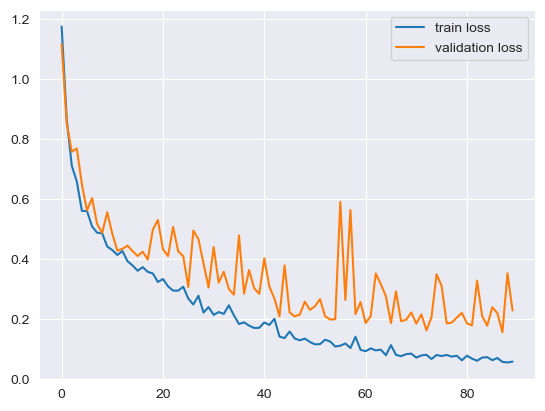

In [17]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.show()

# **TEST & EVALUATION**



In [18]:
# Calculate Train and Validation Accuracy

def cal_accuracy(data_loader):
    n_correct = 0
    n_total = 0
    
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    accuracy = n_correct / n_total

    return accuracy


print(f"Train Accuracy: {cal_accuracy(train_loader):.4f}, Validation Accuracy: {cal_accuracy(validation_loader):.4f}, Test Accuracy: {cal_accuracy(test_loader):.4f}")

Train Accuracy: 0.9841, Validation Accuracy: 0.9560, Test Accuracy: 0.9435


In [19]:
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        y_true_list.append(targets.cpu().numpy())
        y_pred_list.append(predictions.cpu().numpy())

# flatten data of batches into a 1-d list
y_true_list = list(np.concatenate(y_true_list).flat)
y_pred_list = list(np.concatenate(y_pred_list).flat)

In [20]:
# Classification Report

print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       105
           1       0.97      0.94      0.95       111
           2       0.94      0.89      0.91       102
           3       0.92      0.96      0.94       107

    accuracy                           0.94       425
   macro avg       0.94      0.94      0.94       425
weighted avg       0.94      0.94      0.94       425



In [21]:
# Confusion Matrix

print(confusion_matrix(y_true_list, y_pred_list))

[[103   1   0   1]
 [  0 104   4   3]
 [  6   0  91   5]
 [  0   2   2 103]]


<AxesSubplot: >

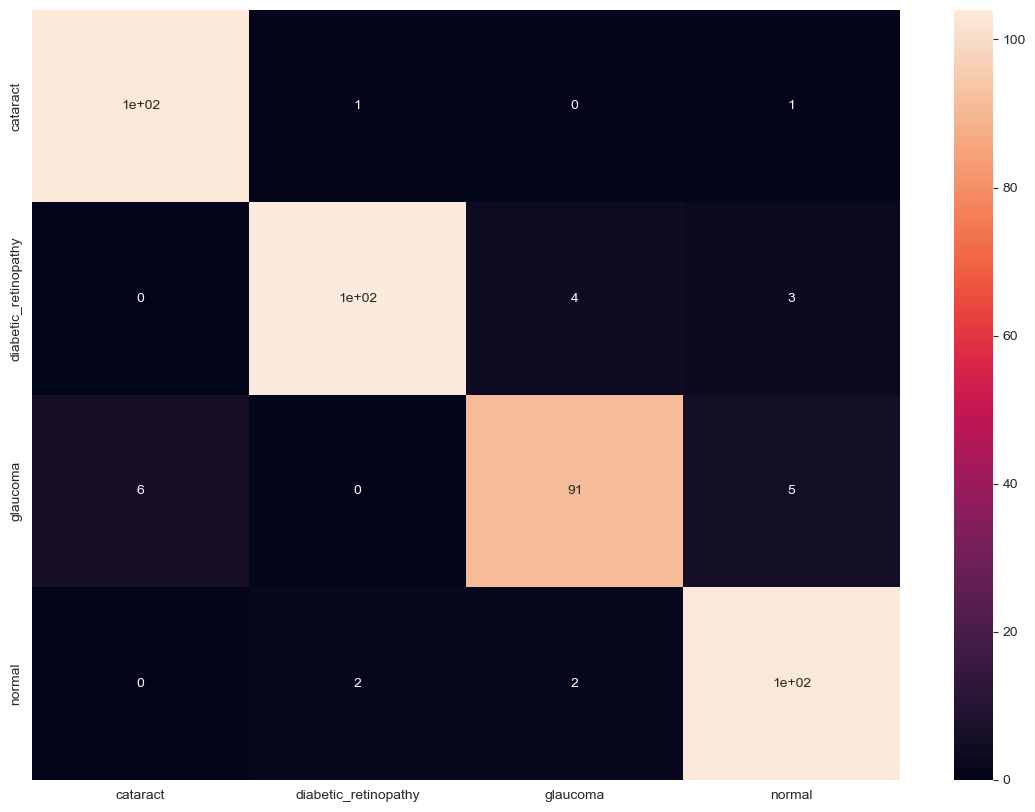

In [22]:
# Plot the Confusion Matrix

def plot_confusion_matrix(dataset, y_true_list, y_pred_list):
    index_to_label = {v:k for k, v in dataset.class_to_idx.items()}
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=index_to_label, index=index_to_label)
    fig, ax = plt.subplots(figsize=(14,10))         
    return sns.heatmap(confusion_matrix_df, annot=True, ax=ax)


plot_confusion_matrix(test_set, y_true_list, y_pred_list)

# **MISCLASSIFIED SAMPLES**

25 of Misclassified Images:


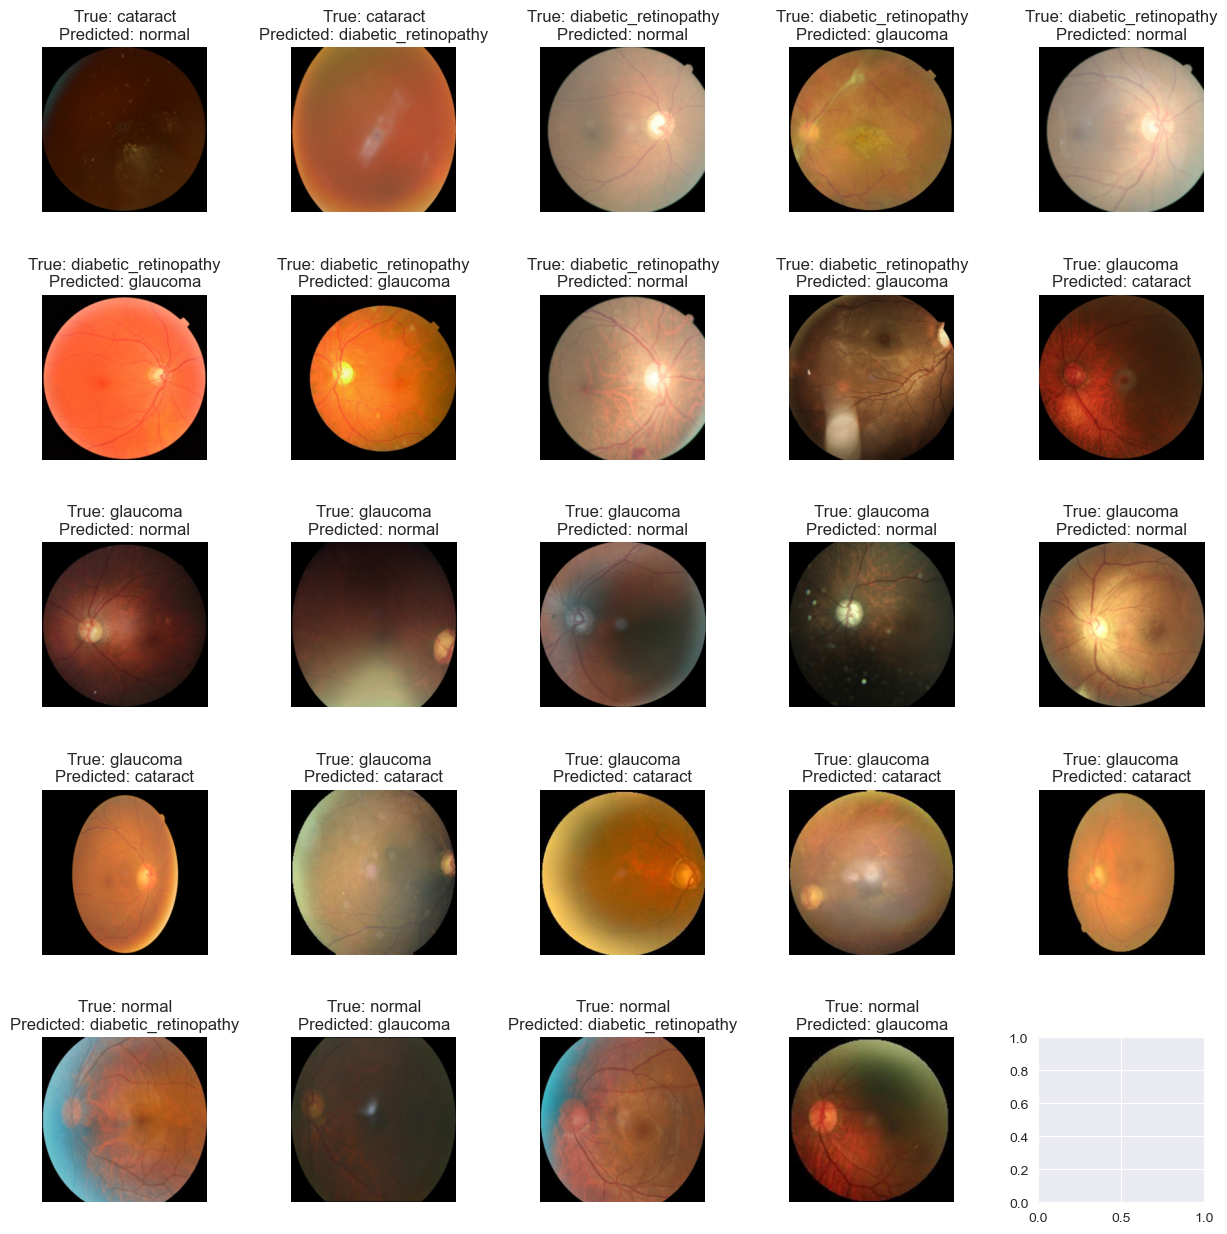

In [23]:
# Plot some of misclassified instances

n_missclassified = 25

encoded_labels = {v:k for k, v in train_set.class_to_idx.items()}
misclassified_idx = np.where(np.array(y_true_list) != np.array(y_pred_list))[0]

print(f"{n_missclassified} of Misclassified Images:")
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, mis_index in enumerate(misclassified_idx[:n_missclassified]):
    ax = axes.ravel()[i]
    ax.imshow(test_set[mis_index][0].permute(1, 2, 0))
    ax.set_title(f"True: {encoded_labels[y_true_list[mis_index]]}\nPredicted: {encoded_labels[y_pred_list[mis_index]]}")
    ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()